In [ ]:
!nvidia-smi
!pip install ultralytics==8.3.213
!pip install roboflow
!pip install ultralytics==8.3.213 matplotlib seaborn
!nvidia-smi
import matplotlib.pyplot as plt
import seaborn as sns

# prepare model

Sat Nov 29 17:08:09 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA A100-SXM4-40GB          Off |   00000000:00:04.0 Off |                    0 |
| N/A   32C    P0             45W /  400W |       0MiB /  40960MiB |      0%      Default |
|                                         |                        |             Disabled |
+-----------------------------------------+-----

In [ ]:
# =========================================================
# SUPER-LIGHT YOLO CONVERSION (Final Optimized)
# Combine: GhostConv + DepthwiseConv + GroupConv + ECA + BN Fusion
# Author: Thanh Pham
# =========================================================

from ultralytics import YOLO
from torch import nn
import torch, os
from ultralytics.nn.modules.block import C2f

# ======= Load model (YOLOv11n / or your trained one) =======
model = YOLO("yolo11n.pt")  # or path to custom model
base_params = sum(p.numel() for p in model.model.parameters()) / 1e6
print(f"Loaded model: {base_params:.2f}M params")


# ======= Ghost all backbone

# ======= Define lightweight conv modules =======
class DepthwiseSeparableConv(nn.Module):
    """Depthwise + Pointwise convolution"""
    def __init__(self, in_channels, out_channels, k=3, s=1, p=1):
        super().__init__()
        self.depthwise = nn.Conv2d(in_channels, in_channels, k, s, p, groups=in_channels, bias=False)
        self.pointwise = nn.Conv2d(in_channels, out_channels, 1, 1, 0, bias=False)
        self.bn = nn.BatchNorm2d(out_channels)
        self.act = nn.SiLU()

    def forward(self, x):
        return self.act(self.bn(self.pointwise(self.depthwise(x))))

class GhostConv(nn.Module):
    """GhostConv block"""
    def __init__(self, in_ch, out_ch, k=3, s=1):
        super().__init__()
        init_ch = out_ch // 2
        self.primary = nn.Conv2d(in_ch, init_ch, k, s, 1, bias=False)
        self.cheap = nn.Conv2d(init_ch, out_ch - init_ch, 1, 1, 0, bias=False)
        self.bn = nn.BatchNorm2d(out_ch)
        self.act = nn.SiLU()

    def forward(self, x):
        y = torch.cat([self.primary(x), self.cheap(self.primary(x))], dim=1)
        return self.act(self.bn(y))

class ECALayer(nn.Module):
    """Efficient Channel Attention"""
    def __init__(self, channels, k_size=3):
        super().__init__()
        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        self.conv = nn.Conv1d(1, 1, kernel_size=k_size, padding=(k_size - 1)//2, bias=False)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        y = self.avg_pool(x)
        y = self.conv(y.squeeze(-1).transpose(-1, -2))
        y = self.sigmoid(y).transpose(-1, -2).unsqueeze(-1)
        return x * y.expand_as(x)

# ======= Replace Conv2d → GhostConv / Depthwise / GroupConv + ECA =======
def replace_conv_layers(model):
    for name, module in model.named_children():
        if isinstance(module, nn.Conv2d):
            in_ch, out_ch, k, s = module.in_channels, module.out_channels, module.kernel_size[0], module.stride[0]
            if in_ch >= 64:  # deep layers
                new_layer = nn.Sequential(GhostConv(in_ch, out_ch, k, s), ECALayer(out_ch))
            elif in_ch >= 16:  # middle layers
                new_layer = nn.Sequential(DepthwiseSeparableConv(in_ch, out_ch, k, s), ECALayer(out_ch))
            else:  # shallow
                new_layer = nn.Sequential(
                    nn.Conv2d(in_ch, out_ch, k, s, 1, groups=max(1, in_ch//4), bias=False),
                    nn.BatchNorm2d(out_ch),
                    nn.SiLU()
                )
            setattr(model, name, new_layer)
        else:
            replace_conv_layers(module)

replace_conv_layers(model.model)
print("Replaced Conv → Ghost/Depthwise/GroupConv + ECA")

# ======= Fuse Conv + BN (LightConv fusion) =======
def fuse_conv_bn(conv, bn):
    with torch.no_grad():
        fused = nn.Conv2d(conv.in_channels, conv.out_channels, conv.kernel_size,
                          stride=conv.stride, padding=conv.padding, bias=True)
        w_bn = bn.weight / torch.sqrt(bn.running_var + bn.eps)
        fused.weight.copy_(conv.weight * w_bn[:, None, None, None])
        fused.bias.copy_(bn.bias - bn.running_mean * w_bn)
    return fused

def fuse_model(model):
    for name, module in model.named_children():
        if isinstance(module, nn.Sequential):
            modules = list(module.children())
            for i in range(len(modules) - 1):
                if isinstance(modules[i], nn.Conv2d) and isinstance(modules[i + 1], nn.BatchNorm2d):
                    fused = fuse_conv_bn(modules[i], modules[i + 1])
                    modules[i] = fused
                    modules.pop(i + 1)
                    break
            setattr(model, name, nn.Sequential(*modules))
        else:
            fuse_model(module)

fuse_model(model.model)
print("Fused Conv + BN layers (LightConv active)")
final_params = sum(p.numel() for p in model.model.parameters()) / 1e6
reduction = 100 * (1 - final_params / base_params)
print(f"Reduced parameters: {base_params:.2f}M → {final_params:.2f}M  (~{reduction:.1f}% reduction)")

# ======= Save model =======
os.makedirs("optimized_models", exist_ok=True)
torch.save(model.model.state_dict(), "optimized_models/yolo11n_superlight_final.pt")
print("Saved: optimized_models/yolo11n_superlight_final.pt")


Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.
Loaded model: 2.62M params
Replaced Conv → Ghost/Depthwise/GroupConv + ECA
Fused Conv + BN layers (LightConv active)
Reduced parameters: 2.62M → 2.14M  (~18.4% reduction)
Saved: optimized_models/yolo11n_superlight_final.pt


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# =========================================================
# SMART RECURSIVE PRUNING (L1-norm)
# Properly traverses YOLOv11 nested modules (C2f, Sequential)
# =========================================================
import torch
from torch import nn
from ultralytics import YOLO

# ===== Load optimized superlight model =====
base = YOLO("yolo11n.pt")
m = base.model
state = torch.load("optimized_models/yolo11n_superlight_final.pt", map_location="cpu")
m.load_state_dict(state, strict=False)
print("Loaded weights from superlight_final.pt")

# ===== Config =====
PRUNE_RATIO = 0.6
print(f" Pruning ratio: {PRUNE_RATIO*100:.0f}%")

# ===== Core pruning function =====
def prune_conv(conv, ratio=0.4):
    w = conv.weight.data.abs().clone()
    l1 = w.view(w.size(0), -1).sum(dim=1)
    keep = int(w.size(0) * (1 - ratio))
    if keep < 1:
        return conv  # skip tiny convs
    idx = torch.topk(l1, keep, largest=True)[1]
    new_conv = nn.Conv2d(
        conv.in_channels, keep,
        kernel_size=conv.kernel_size, stride=conv.stride,
        padding=conv.padding, bias=(conv.bias is not None)
    )
    new_conv.weight.data = conv.weight.data[idx]
    if conv.bias is not None:
        new_conv.bias.data = conv.bias.data[idx]
    return new_conv

# ===== Recursive pruning =====
def recursive_prune(module, ratio=0.4):
    for name, child in module.named_children():
        if isinstance(child, nn.Conv2d):
            pruned = prune_conv(child, ratio)
            setattr(module, name, pruned)
        else:
            recursive_prune(child, ratio)

recursive_prune(m, PRUNE_RATIO)

# ===== Save pruned model =====
torch.save(m.state_dict(), "optimized_models/yolo11n_pruned.pt")
params = sum(p.numel() for p in m.parameters()) / 1e6
print(f"Pruned model saved: yolo11n_pruned.pt ({params:.2f}M params)")
torch.save(m, "optimized_models/yolo11n_pruned_full.pt")
print("Saved full pruned model (includes architecture).")


Loaded weights from superlight_final.pt
 Pruning ratio: 60%
Pruned model saved: yolo11n_pruned.pt (1.05M params)
Saved full pruned model (includes architecture).


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

# Đường dẫn dataset trong Drive (nơi có data.yaml, train/, val/)
DATASET_DIR = "/content/drive/MyDrive/yolo_mtid_motor"

# Đường dẫn project (nơi YOLO lưu kết quả train)
PROJECT_DIR = "/content/drive/MyDrive/yolo_customzied"

!mkdir -p {PROJECT_DIR}
%cd {PROJECT_DIR}


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/MyDrive/yolo_customzied


In [ ]:
from ultralytics import YOLO
import torch
from ultralytics.nn.tasks import DetectionModel
torch.serialization.add_safe_globals([DetectionModel])

# =====================================================
#  PHASE 2: Load pruned model (full architecture)
# =====================================================
m = torch.load("/content/optimized_models/yolo11n_pruned_full.pt", map_location="cpu", weights_only=False)
os.environ.pop('CUDA_VISIBLE_DEVICES', None)
device_arg = 'cpu'
model = YOLO("yolo11n.pt")
model.model = m
model.info()

# =====================================================
#  PHASE 3: train
# =====================================================
results = model.train(
    data=f"{DATASET_DIR}/data.yaml",
    epochs=30,
    imgsz=640,
    device=0,
    cache=True,
    amp=True,
    cos_lr=True,
    resume = True,
    lr = 0.00005,
    patience=10,
    warmup_epochs = 10,
    project=PROJECT_DIR,
    name="yolo11n_pruned_test_1"
)

YOLO11n summary: 181 layers, 1,045,962 parameters, 1,030,282 gradients
New https://pypi.org/project/ultralytics/8.3.228 available 😃 Update with 'pip install -U ultralytics'
Ultralytics 8.3.213 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=True, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=True, cutmix=0.0, data=/content/drive/MyDrive/yolo_mtid_motor/data.yaml, degrees=0.0, deterministic=True, device=0, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=30, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolo11n.pt, mo

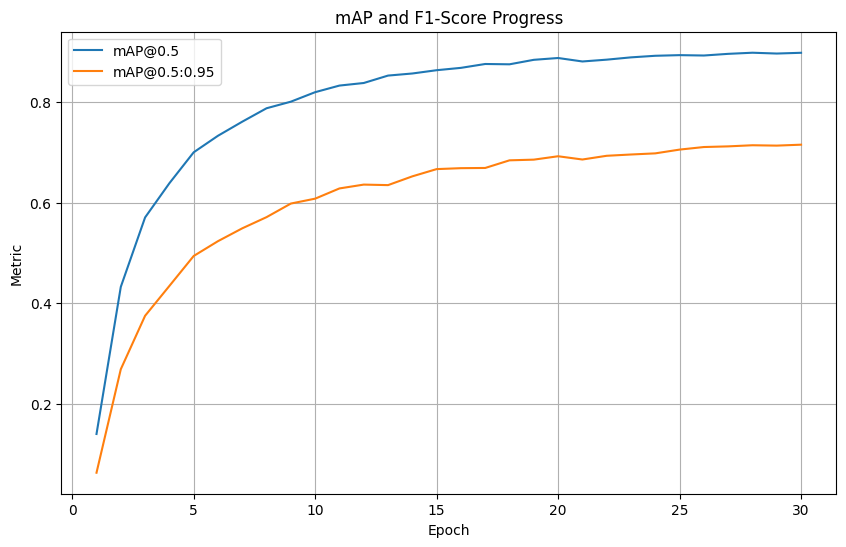

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
import os

# Construct the path to the results.csv file
results_path = os.path.join(PROJECT_DIR, "yolo11n_pruned_test_1", "results.csv")

# Read the results.csv file into a pandas DataFrame
df = pd.read_csv(results_path)

plt.figure(figsize=(10,6))
plt.plot(df['epoch'], df['metrics/mAP50(B)'], label='mAP@0.5')
plt.plot(df['epoch'], df['metrics/mAP50-95(B)'], label='mAP@0.5:0.95')
plt.xlabel('Epoch')
plt.ylabel('Metric')
plt.title('mAP and F1-Score Progress')
plt.legend()
plt.grid(True)
plt.show()

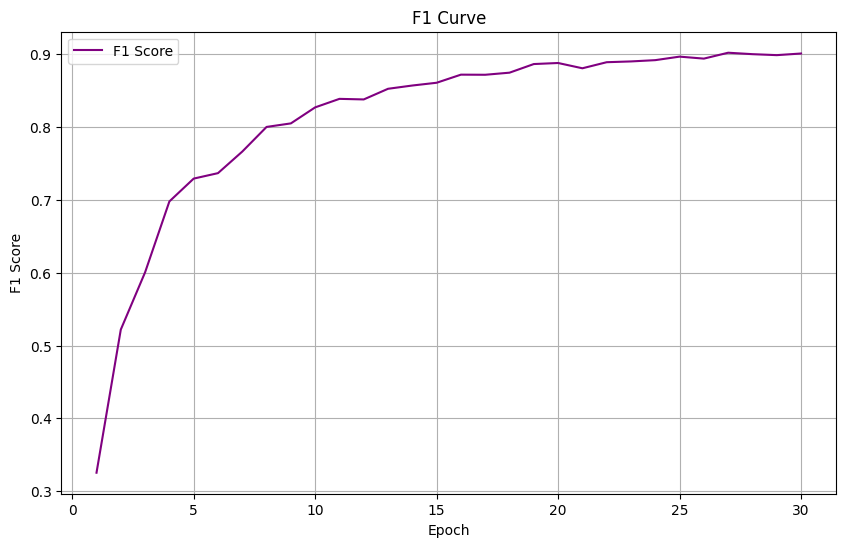

In [ ]:
plt.figure(figsize=(10,6))
f1 = 2 * (df['metrics/precision(B)'] * df['metrics/recall(B)']) / (df['metrics/precision(B)'] + df['metrics/recall(B)'])
plt.plot(df['epoch'], f1, label='F1 Score', color='purple')
plt.xlabel('Epoch')
plt.ylabel('F1 Score')
plt.title('F1 Curve')
plt.legend()
plt.grid(True)
plt.show()


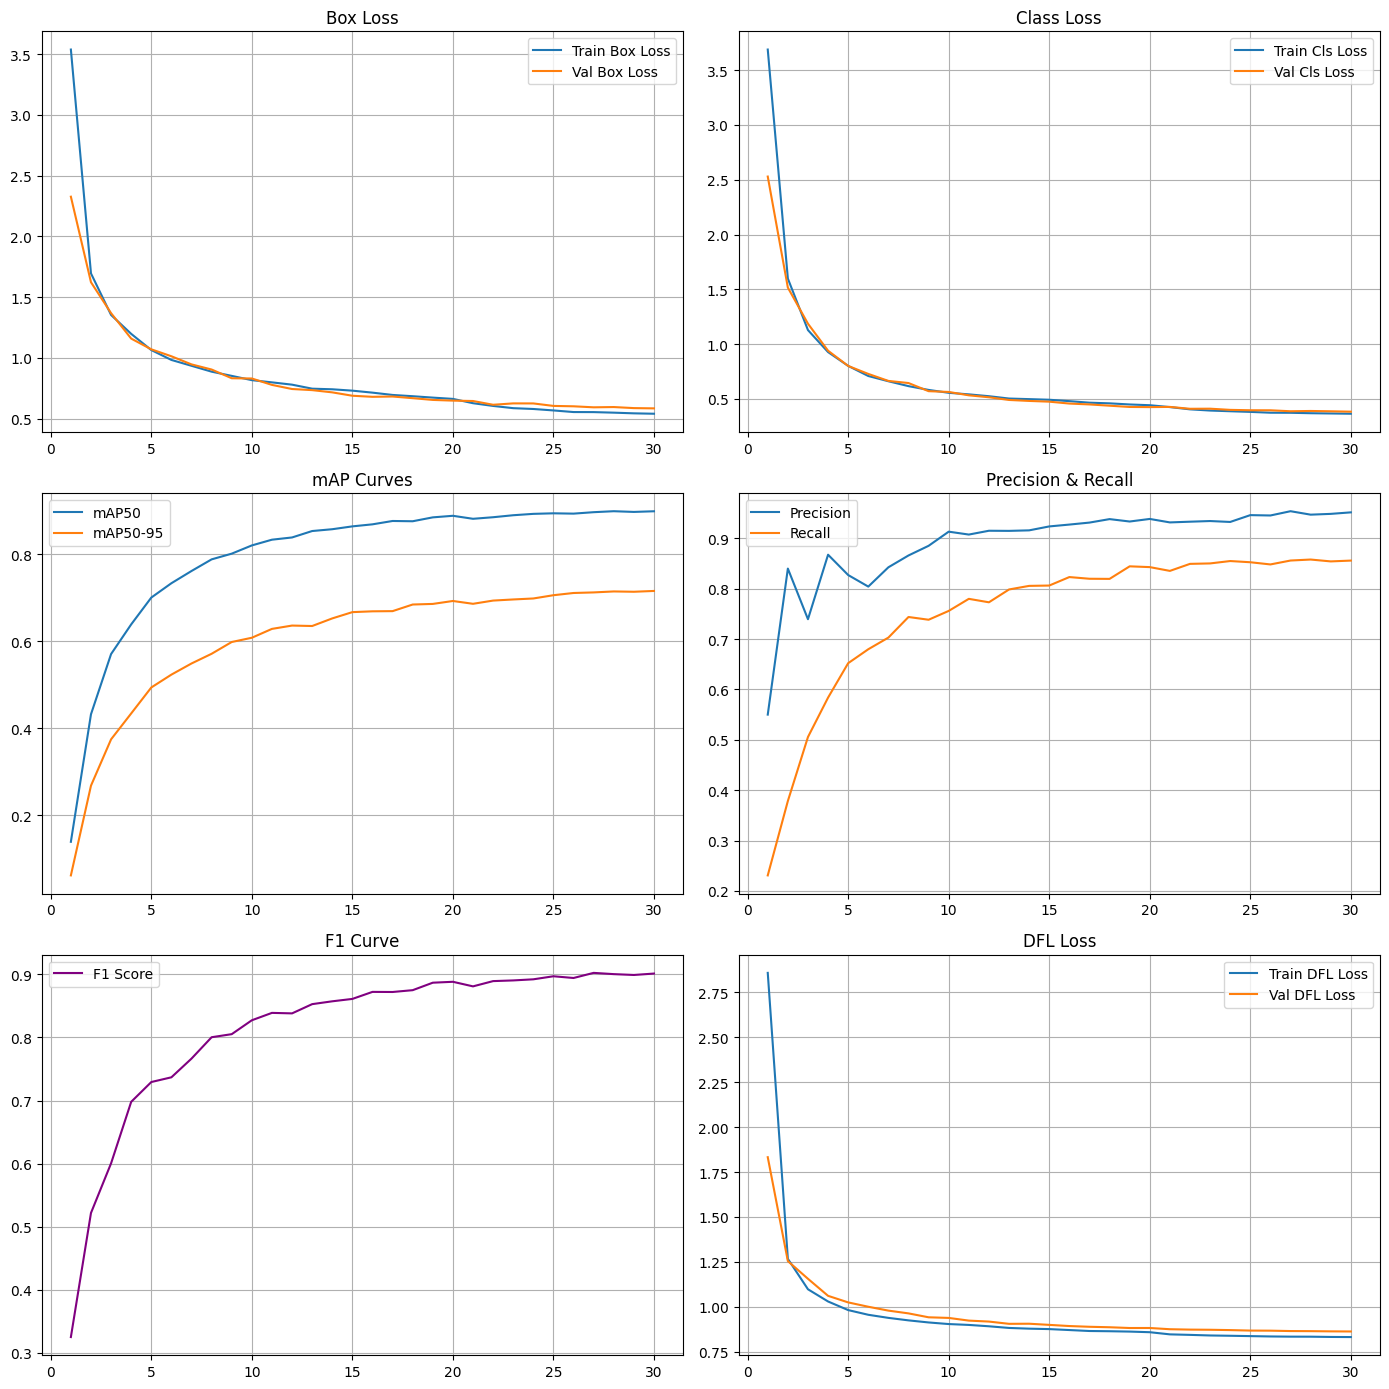

In [ ]:
fig, axes = plt.subplots(3, 2, figsize=(14, 14))

axes[0,0].plot(df['epoch'], df['train/box_loss'], label='Train Box Loss')
axes[0,0].plot(df['epoch'], df['val/box_loss'], label='Val Box Loss')
axes[0,0].set_title('Box Loss'); axes[0,0].legend(); axes[0,0].grid()

axes[0,1].plot(df['epoch'], df['train/cls_loss'], label='Train Cls Loss')
axes[0,1].plot(df['epoch'], df['val/cls_loss'], label='Val Cls Loss')
axes[0,1].set_title('Class Loss'); axes[0,1].legend(); axes[0,1].grid()

axes[1,0].plot(df['epoch'], df['metrics/mAP50(B)'], label='mAP50')
axes[1,0].plot(df['epoch'], df['metrics/mAP50-95(B)'], label='mAP50-95')
axes[1,0].set_title('mAP Curves'); axes[1,0].legend(); axes[1,0].grid()

axes[1,1].plot(df['epoch'], df['metrics/precision(B)'], label='Precision')
axes[1,1].plot(df['epoch'], df['metrics/recall(B)'], label='Recall')
axes[1,1].set_title('Precision & Recall'); axes[1,1].legend(); axes[1,1].grid()

f1 = 2 * (df['metrics/precision(B)'] * df['metrics/recall(B)']) / (df['metrics/precision(B)'] + df['metrics/recall(B)'])
axes[2,0].plot(df['epoch'], f1, label='F1 Score', color='purple')
axes[2,0].set_title('F1 Curve'); axes[2,0].legend(); axes[2,0].grid()

axes[2,1].plot(df['epoch'], df['train/dfl_loss'], label='Train DFL Loss')
axes[2,1].plot(df['epoch'], df['val/dfl_loss'], label='Val DFL Loss')
axes[2,1].set_title('DFL Loss'); axes[2,1].legend(); axes[2,1].grid()


plt.tight_layout()
plt.show()

#FINETUNE FUNCTION

In [ ]:
from ultralytics import YOLO

# Load pruned model correctly
model = YOLO("/content/drive/MyDrive/yolo_customzied/yolo11n_pruned_test_1/weights/best.pt")

# Train
model.train(
    data=f"{DATASET_DIR}/data.yaml",
    epochs=50,
    imgsz=640,
    device=0,
    cache=True,
    amp=True,
    cos_lr=True,
    resume=False,   # cần OFF, vì resume = True sẽ yêu cầu last.pt
    lr0=5e-5,
    patience=15,
    warmup_epochs=10,
    project=PROJECT_DIR,
    name="yolo11n_pruned_finetune_phase2"
)


New https://pypi.org/project/ultralytics/8.3.233 available 😃 Update with 'pip install -U ultralytics'
Ultralytics 8.3.213 🚀 Python-3.12.12 torch-2.9.0+cu126 CUDA:0 (NVIDIA A100-SXM4-40GB, 40507MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=True, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=True, cutmix=0.0, data=/content/drive/MyDrive/yolo_mtid_motor/data.yaml, degrees=0.0, deterministic=True, device=0, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=50, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=5e-05, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=/content/drive/MyDrive/yolo_customzied/yolo11n_pruned_test_1/weights/be

ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0, 1, 2, 3, 4])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x7a42ecdeaf60>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042,    0.043043,    0.044044,    0.045045,    0.046046,    0.047047,
        